In [56]:

import os
import pandas as pd

LOG_DIR = "D:/Workspace/DDL/Data/the-attentive-cursor-dataset/logs"

dfs = []

for f in os.listdir(LOG_DIR):
    if f.endswith(".csv"):
        log_id = f.replace(".csv","")
        path = os.path.join(LOG_DIR, f)

        df = pd.read_csv(
            path,
            sep=" ",
            names=["cursor","timestamp","xpos","ypos","event","xpath","attrs","extras"],
            header=None,  # Tắt tính năng tự động phát hiện/gán header
            skiprows=1    # Bỏ qua hàng đầu tiên (chính là header gốc)
        )

        df["log_id"] = log_id
        # Dòng này sẽ hoạt động vì hàng đầu tiên (chứa chuỗi "timestamp") đã bị bỏ qua
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        dfs.append(df)

cursor_df = pd.concat(dfs, ignore_index=True)
cursor_df.to_parquet("cursor.parquet", index=False)

print("✅ Cursor rows:", len(cursor_df))

✅ Cursor rows: 106341


In [57]:
gt = pd.read_csv("D:/Workspace/DDL/Data/the-attentive-cursor-dataset/groundtruth.tsv", sep="\t")
participants = pd.read_csv("D:/Workspace/DDL/Data/the-attentive-cursor-dataset/participants.tsv", sep="\t")

print("Kiểu dữ liệu trong cursor_df:")
print(cursor_df.dtypes)
print("\nKiểu dữ liệu trong gt:")
print(gt.dtypes)
print("\nKiểu dữ liệu trong participants:")
print(participants.dtypes)

Kiểu dữ liệu trong cursor_df:
cursor                int64
timestamp    datetime64[ns]
xpos                float64
ypos                float64
event                object
xpath                object
attrs                object
extras               object
log_id               object
dtype: object

Kiểu dữ liệu trong gt:
user_id       object
ad_clicked     int64
attention      int64
log_id         int64
dtype: object

Kiểu dữ liệu trong participants:
user_id        object
country        object
education      object
age            object
income         object
gender         object
ad_position    object
ad_type        object
ad_category    object
serp_id        object
query          object
log_id          int64
dtype: object


In [58]:
# Đảm bảo cột log_id trong cursor_df là kiểu chuỗi (object)
# (Thường là mặc định nếu bạn tạo nó từ tên file)
cursor_df['log_id'] = cursor_df['log_id'].astype(str)

# 1. Đọc và chuyển đổi cột khóa của gt và participants
gt = pd.read_csv("D:/Workspace/DDL/Data/the-attentive-cursor-dataset/groundtruth.tsv", sep="\t")
participants = pd.read_csv("D:/Workspace/DDL/Data/the-attentive-cursor-dataset/participants.tsv", sep="\t")

# Chuyển đổi kiểu dữ liệu của cột khóa sang chuỗi (string/object)
gt['log_id'] = gt['log_id'].astype(str)
participants['log_id'] = participants['log_id'].astype(str)

# 2. Thực hiện Merge
merged = cursor_df.merge(gt, on="log_id", how="left") \
                 .merge(participants, on="log_id", how="left")

merged.to_parquet("attentive_cursor.parquet", index=False)
print("✅ Final dataset ready")

✅ Final dataset ready


In [59]:
from cassandra.cluster import Cluster
print("import ok")


import ok


In [60]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.concurrent import execute_concurrent

cluster = Cluster(["127.0.0.1"])
session = cluster.connect()


In [61]:
session.execute("""
CREATE KEYSPACE IF NOT EXISTS attentive
WITH replication = {
  'class': 'SimpleStrategy',
  'replication_factor': 1
}
""")


In [62]:
session.set_keyspace("attentive")


In [63]:
session.execute("""
CREATE TABLE IF NOT EXISTS cursor_events (
    log_id text,
    timestamp timestamp,
    event text,
    xpos float,
    ypos float,
    user_id text,
    attention int,
    ad_clicked int,
    ad_position text,
    ad_type text,
    ad_category text,
    PRIMARY KEY ((log_id), timestamp)
) WITH CLUSTERING ORDER BY (timestamp ASC)
""")


In [72]:
# Sửa lại câu lệnh INSERT (stmt)
stmt = session.prepare("""
    INSERT INTO cursor_events (
        log_id, timestamp, event, xpos, ypos, user_id, 
        attention, ad_clicked, ad_position, ad_type, ad_category,
        country, education, age, income, gender, serp_id, query 
    ) 
    VALUES (
        ?, ?, ?, ?, ?, ?, 
        ?, ?, ?, ?, ?,
        ?, ?, ?, ?, ?, ?, ?
    )
""")


In [65]:
print(merged.columns)


Index(['cursor', 'timestamp', 'xpos', 'ypos', 'event', 'xpath', 'attrs',
       'extras', 'log_id', 'user_id_x', 'ad_clicked', 'attention', 'user_id_y',
       'country', 'education', 'age', 'income', 'gender', 'ad_position',
       'ad_type', 'ad_category', 'serp_id', 'query'],
      dtype='object')


In [66]:
# Tạo cột user_id hợp nhất
merged['user_id'] = merged['user_id_x'].combine_first(merged['user_id_y'])

# Kiểm tra kết quả
merged[['user_id_x', 'user_id_y', 'user_id']].head()

,user_id_x,user_id_y,user_id
0,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190
1,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190
2,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190
3,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190
4,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190,2fq3fhu6r693jl2sdb8fhbd190


In [74]:
data = []
# Giả định: DataFrame Pandas có đủ các cột meta này
merged.loc[merged['age'].astype(str).str.lower() == 'na', 'age'] = pd.NA
for _, r in merged.iterrows():
    params = (
        r.log_id,
        r.timestamp.to_pydatetime(),
        r.event,
        float(r.xpos),
        float(r.ypos),
        r.user_id,
        int(r.attention) if pd.notna(r.attention) else None,
        int(r.ad_clicked) if pd.notna(r.ad_clicked) else None,
        r.ad_position,
        r.ad_type,
        r.ad_category,
        # THÊM CÁC CỘT META MỚI
        r.country if pd.notna(r.country) else None,
        r.education if pd.notna(r.education) else None,
        int(r.age) if pd.notna(r.age) else None,
        r.income if pd.notna(r.income) else None,
        r.gender if pd.notna(r.gender) else None,
        r.serp_id if pd.notna(r.serp_id) else None,
        r.query if pd.notna(r.query) else None
    )
    data.append((stmt, params))


In [75]:
from cassandra.concurrent import execute_concurrent
# ... (imports và thiết lập khác) ...

# Giả định: data là list các tuples (stmt, parameters)
# Giả định: session đã được kết nối

results = execute_concurrent(
    session,
    data,
    concurrency=50 # Sử dụng concurrency hợp lý (ví dụ: 50-100)
)

failed_inserts = 0
successful_inserts = 0

# Lặp qua kết quả để kiểm tra thất bại
for success, result in results:
    if not success:
        # Nếu thất bại, result là đối tượng Exception
        failed_inserts += 1
        # Ghi lại lỗi chi tiết
        print(f"❌ Lỗi chèn: {result}")
        # THÊM LOGIC THỬ LẠI HOẶC GHI LẠI TỆP DỮ LIỆU BỊ LỖI NẾU CẦN
    else:
        successful_inserts += 1

print(f"✅ Insert done. Thành công: {successful_inserts}, Thất bại: {failed_inserts}")

if failed_inserts > 0:
    # Nếu có lỗi, bạn có thể quyết định dừng lại hoặc thử chèn lại
    print("⚠️ CẢNH BÁO: Có bản ghi thất bại. Vui lòng kiểm tra log lỗi.")


✅ Insert done. Thành công: 106341, Thất bại: 0


In [100]:
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement
from cassandra import ConsistencyLevel

# ===============================
# 1. Kết nối
# ===============================
cluster = Cluster(['127.0.0.1']) 
session = cluster.connect('attentive')

# ===============================
# 2. Truy vấn lấy 20 dòng
# ===============================
query = "SELECT * FROM cursor_events LIMIT 100"
statement = SimpleStatement(query, consistency_level=ConsistencyLevel.ONE)

# ===============================
# 3. Thực thi và In kết quả dạng Table
# ===============================
try:
    rows = session.execute(statement)
    
    # Chuyển đổi kết quả (ResultSet) thành list, sau đó đưa vào DataFrame
    # list(rows) sẽ lấy tất cả dữ liệu đã fetch về
    df = pd.DataFrame(list(rows))

    if not df.empty:
        print(f"--- 20 dòng đầu tiên từ bảng cursor_events ---")
        
        # Tùy chỉnh hiển thị của Pandas để không bị cắt bớt cột/dòng
        pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
        pd.set_option('display.width', 1000)        # Mở rộng chiều ngang để không bị xuống dòng
        pd.set_option('display.max_colwidth', 50)   # Giới hạn chiều rộng nội dung cột (cho gọn)

        # In bảng
        print(df)
    else:
        print("Không tìm thấy dữ liệu.")

except Exception as e:
    print(f"Lỗi khi truy vấn: {e}")

# ===============================
# 4. Đóng kết nối
# ===============================
cluster.shutdown()

--- 20 dòng đầu tiên từ bảng cursor_events ---
            log_id               timestamp ad_category  ad_clicked ad_position ad_type  age  attention country education      event  gender income              query            serp_id                     user_id   xpos   ypos
0   20181001162959 2018-10-01 14:32:48.131      Travel           0    top-left  native    1          4     VEN         3       load  female      1  american airlines  american-airlines  dns1069m3hhd5aiq7qlmfo4dk1    0.0    0.0
1   20181001162959 2018-10-01 14:32:48.679      Travel           0    top-left  native    1          4     VEN         3  mousemove  female      1  american airlines  american-airlines  dns1069m3hhd5aiq7qlmfo4dk1  595.0  243.0
2   20181001162959 2018-10-01 14:32:49.204      Travel           0    top-left  native    1          4     VEN         3  mousemove  female      1  american airlines  american-airlines  dns1069m3hhd5aiq7qlmfo4dk1  589.0  244.0
3   20181001162959 2018-10-01 14:32:49.356   

Đã tải file D:/Workspace/DDL/output_analysis/out_activity_hour.csv thành công.
Đã tải file D:/Workspace/DDL/output_analysis/out_attention_position.csv thành công.
Đã tải file D:/Workspace/DDL/output_analysis/out_click_attention.csv thành công.
Đã tải file D:/Workspace/DDL/output_analysis/out_cursor_density.csv thành công.
Đã tải file D:/Workspace/DDL/output_analysis/out_ml_predictions.csv thành công.

--- Biểu đồ 1 & 2: out_activity_hour.csv ---


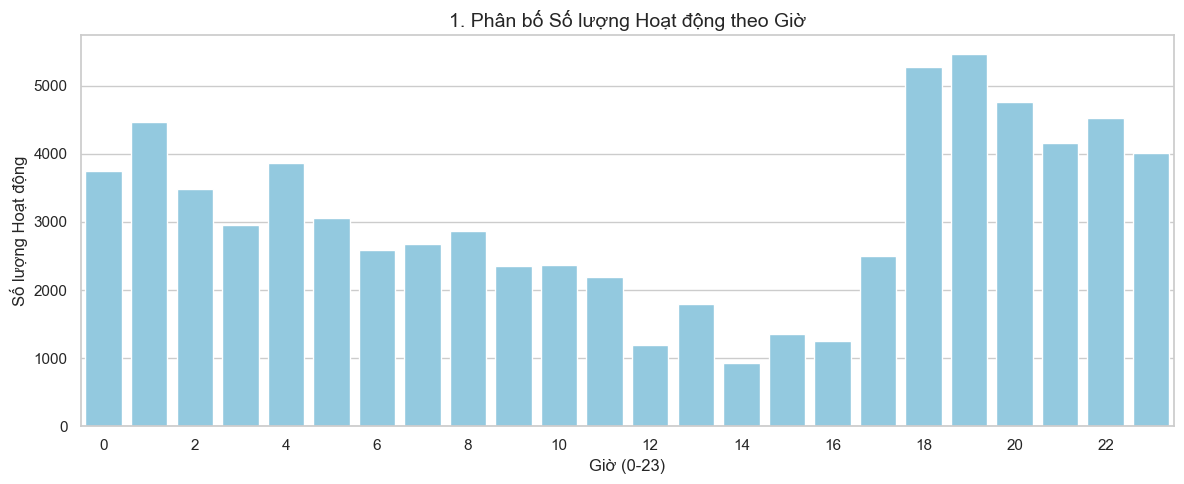

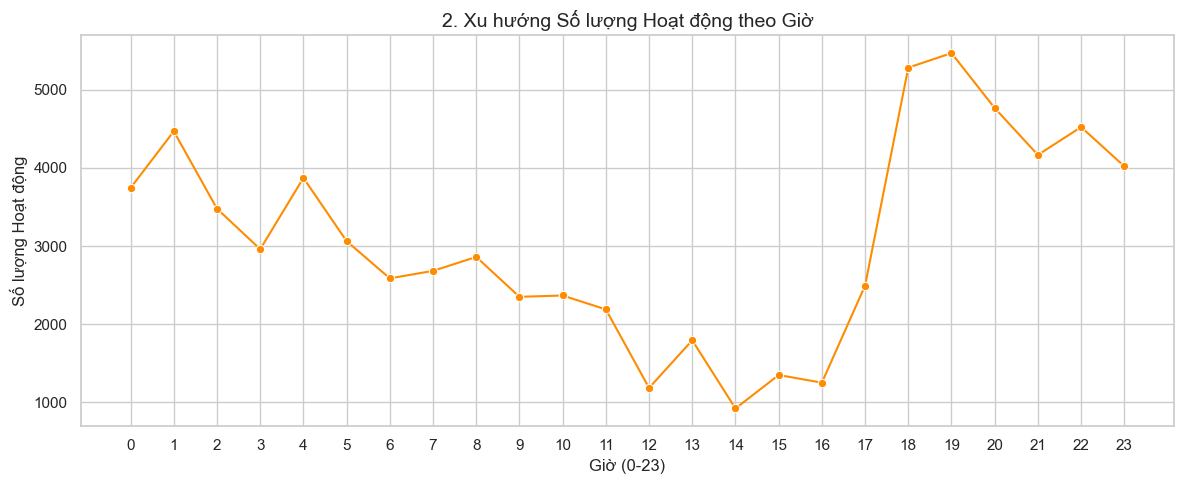


--- Biểu đồ 3 & 4: out_attention_position.csv ---


C:\Users\acer\AppData\Local\Temp\ipykernel_3592\3658486833.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ad_position', y='avg_attention', data=df_position_sorted, palette='viridis')


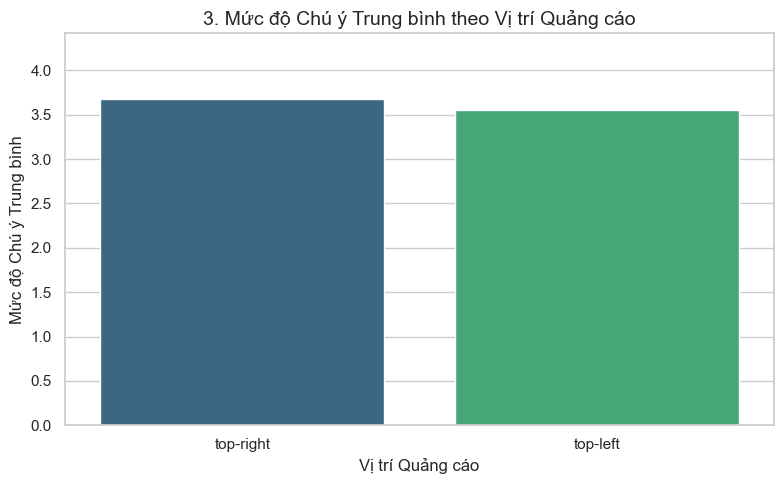

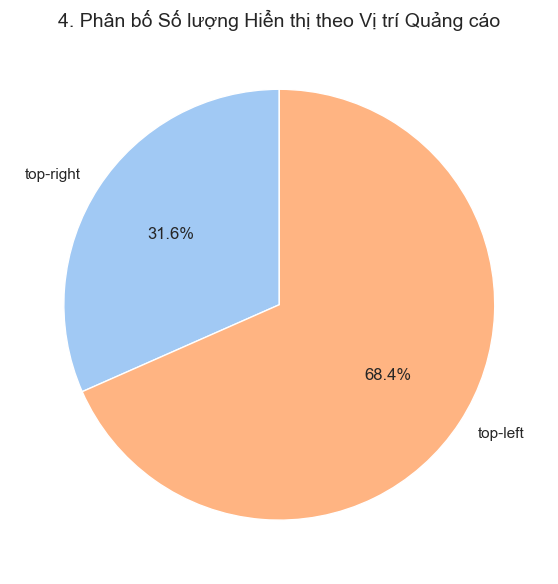


--- Biểu đồ 5 & 6: out_click_attention.csv ---


C:\Users\acer\AppData\Local\Temp\ipykernel_3592\3658486833.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y='avg_attention', data=df_click, palette='magma')


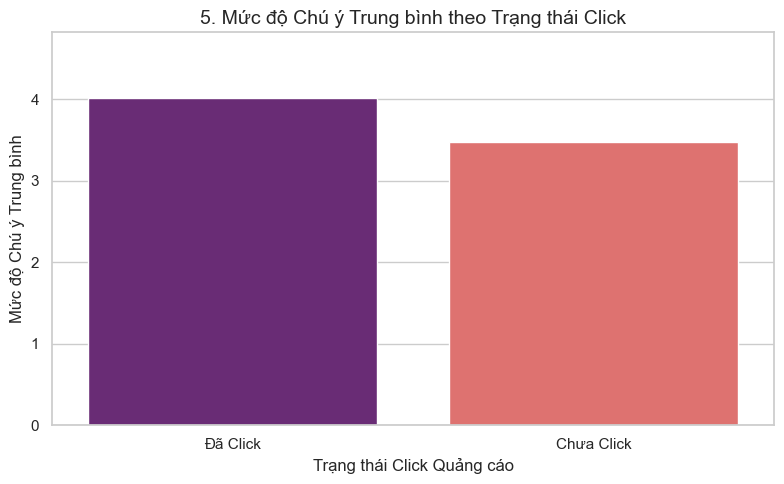

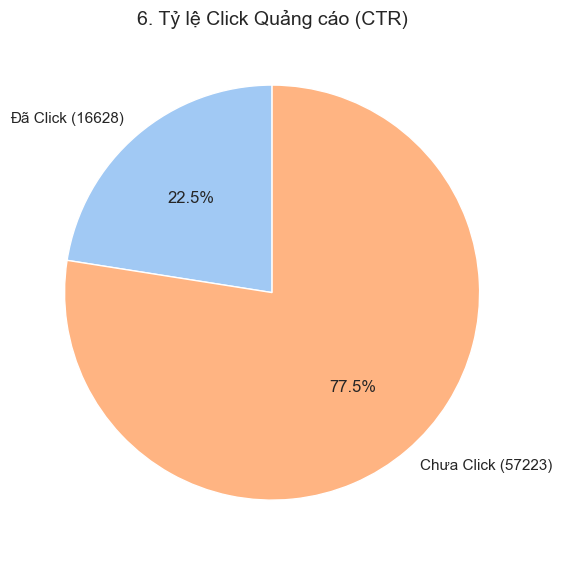


--- Biểu đồ 7: out_cursor_density.csv ---


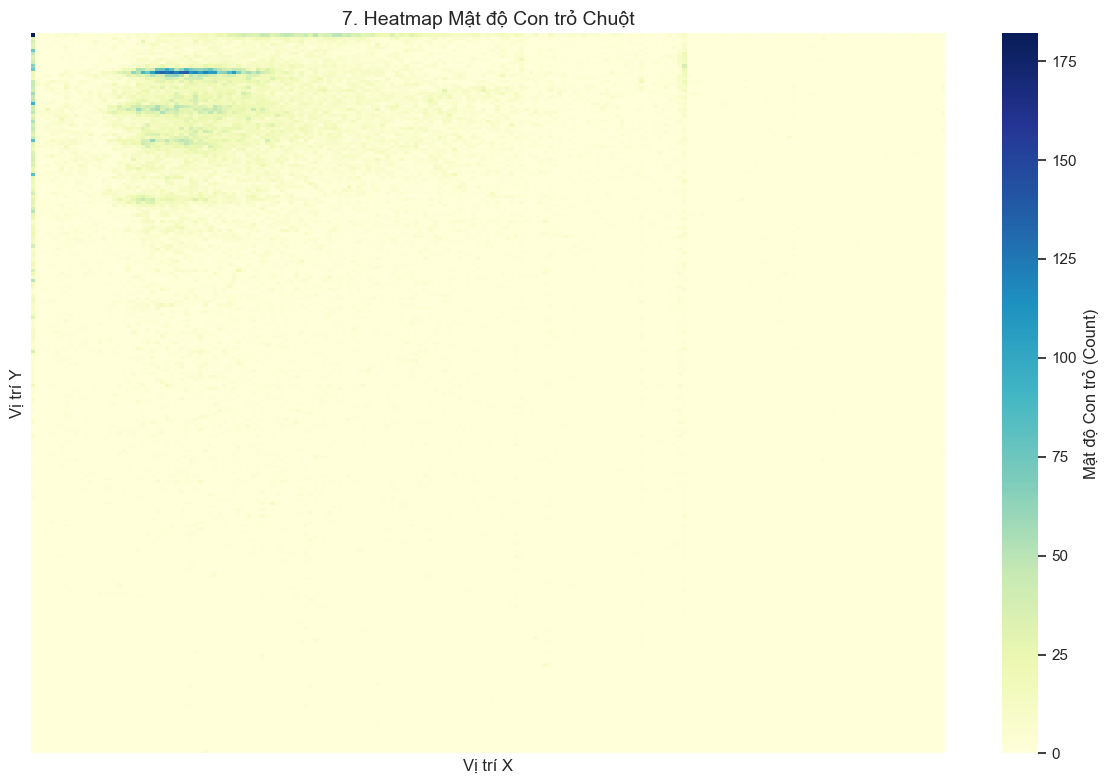


--- Biểu đồ 8 & 9: out_ml_predictions.csv ---


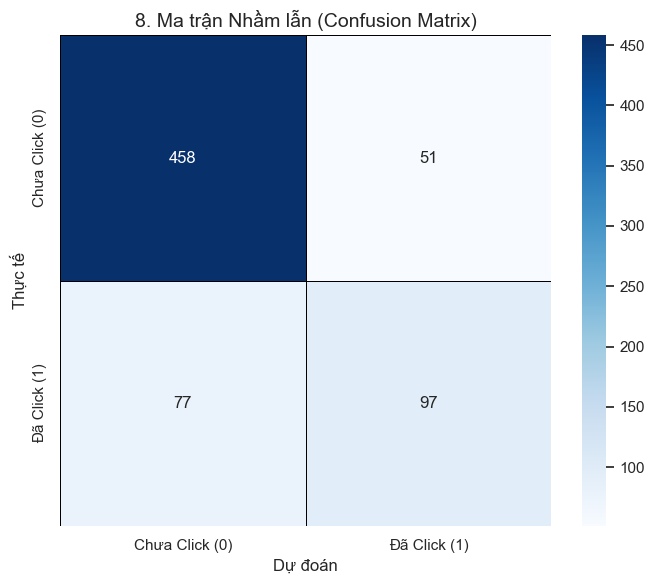

Các cột trong file: Index(['log_id', 'user_id', 'label_ad_clicked', 'prediction', 'prob_click'], dtype='object')


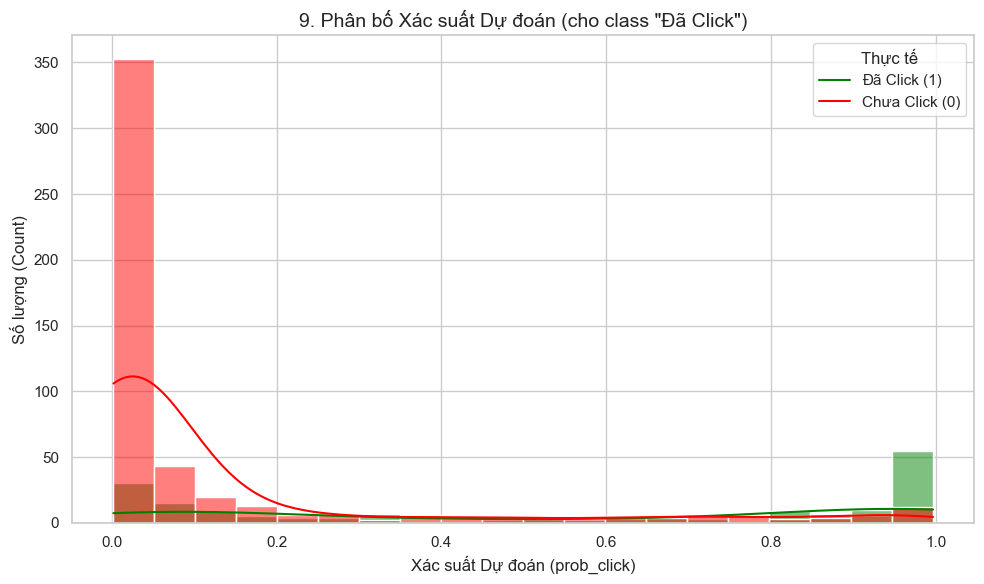

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

# ===============================
# 0️⃣ Cấu hình
# ===============================
# Không cần DATA_DIR vì files là attachments, đọc trực tiếp

# Cấu hình hiển thị
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['figure.figsize'] = (10, 6)

# Danh sách files
files = {
    'activity': 'D:/Workspace/DDL/output_analysis/out_activity_hour.csv',
    'position': 'D:/Workspace/DDL/output_analysis/out_attention_position.csv',
    'click': 'D:/Workspace/DDL/output_analysis/out_click_attention.csv',
    'density': 'D:/Workspace/DDL/output_analysis/out_cursor_density.csv',
    'ml': 'D:/Workspace/DDL/output_analysis/out_ml_predictions.csv'
}

# ===============================
# 1️⃣ Tải Dữ Liệu với kiểm tra tồn tại
# ===============================
dfs = {}
for key, fname in files.items():
    try:
        dfs[key] = pd.read_csv(fname)
        print(f"Đã tải file {fname} thành công.")
    except Exception as e:
        print(f"Lỗi khi tải file {fname}: {e}")
        
# Gán biến tiện dụng
df_activity = dfs.get('activity')
df_position = dfs.get('position')
df_click = dfs.get('click')
df_density = dfs.get('density')
df_ml = dfs.get('ml')

# ===============================
# 2️⃣ Biểu đồ 1 & 2: Hoạt động theo giờ (out_activity_hour.csv)
# ===============================
if df_activity is not None:
    print("\n--- Biểu đồ 1 & 2: out_activity_hour.csv ---")
    # Biểu đồ 1: Cột
    plt.figure(figsize=(12, 5))
    sns.barplot(x='hour', y='count', data=df_activity, color='skyblue')
    plt.title('1. Phân bố Số lượng Hoạt động theo Giờ', fontsize=14)
    plt.xlabel('Giờ (0-23)')
    plt.ylabel('Số lượng Hoạt động')
    plt.xticks(range(0, 24, 2))
    plt.tight_layout()
    plt.show()

    # Biểu đồ 2: Đường
    plt.figure(figsize=(12, 5))
    sns.lineplot(x='hour', y='count', data=df_activity, marker='o', color='darkorange')
    plt.title('2. Xu hướng Số lượng Hoạt động theo Giờ', fontsize=14)
    plt.xlabel('Giờ (0-23)')
    plt.ylabel('Số lượng Hoạt động')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("File out_activity_hour.csv không tồn tại, bỏ qua.")

# ===============================
# 3️⃣ Biểu đồ 3 & 4: Vị trí quảng cáo (out_attention_position.csv)
# ===============================
if df_position is not None:
    print("\n--- Biểu đồ 3 & 4: out_attention_position.csv ---")
    # Biểu đồ 3: Mức độ chú ý trung bình
    df_position_sorted = df_position.sort_values('avg_attention', ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='ad_position', y='avg_attention', data=df_position_sorted, palette='viridis')
    plt.title('3. Mức độ Chú ý Trung bình theo Vị trí Quảng cáo', fontsize=14)
    plt.xlabel('Vị trí Quảng cáo')
    plt.ylabel('Mức độ Chú ý Trung bình')
    plt.ylim(0, df_position['avg_attention'].max() * 1.2)
    plt.tight_layout()
    plt.show()

    # Biểu đồ 4: Phân bố số lượng hiển thị
    plt.figure(figsize=(6, 6))
    plt.pie(df_position['count'], labels=df_position['ad_position'], autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette('pastel')[:len(df_position)])
    plt.title('4. Phân bố Số lượng Hiển thị theo Vị trí Quảng cáo', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("File out_attention_position.csv không tồn tại, bỏ qua.")

# ===============================
# 4️⃣ Biểu đồ 5 & 6: Click & chú ý (out_click_attention.csv)
# ===============================
if df_click is not None:
    print("\n--- Biểu đồ 5 & 6: out_click_attention.csv ---")
    df_click['status'] = df_click['ad_clicked'].map({1: 'Đã Click', 0: 'Chưa Click'})

    # Biểu đồ 5: Mức độ chú ý theo trạng thái click
    plt.figure(figsize=(8, 5))
    sns.barplot(x='status', y='avg_attention', data=df_click, palette='magma')
    plt.title('5. Mức độ Chú ý Trung bình theo Trạng thái Click', fontsize=14)
    plt.xlabel('Trạng thái Click Quảng cáo')
    plt.ylabel('Mức độ Chú ý Trung bình')
    plt.ylim(0, df_click['avg_attention'].max() * 1.2)
    plt.tight_layout()
    plt.show()

    # Biểu đồ 6: Tỷ lệ Click
    plt.figure(figsize=(6, 6))
    total_count = df_click['count'].sum()
    df_click['percentage'] = df_click['count'] / total_count
    labels = [f'{row["status"]} ({row["count"]})' for idx, row in df_click.iterrows()]
    plt.pie(df_click['count'], labels=labels, autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette('pastel')[:len(df_click)])
    plt.title('6. Tỷ lệ Click Quảng cáo (CTR)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("File out_click_attention.csv không tồn tại, bỏ qua.")

# ===============================
# 5️⃣ Biểu đồ 7: Mật độ con trỏ chuột (out_cursor_density.csv)
# ===============================
if df_density is not None:
    print("\n--- Biểu đồ 7: out_cursor_density.csv ---")
    df_pivot = df_density.pivot_table(index='y_group', columns='x_group', values='count', fill_value=0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_pivot, cmap="YlGnBu", cbar_kws={'label': 'Mật độ Con trỏ (Count)'},
                xticklabels=False, yticklabels=False)
    plt.title('7. Heatmap Mật độ Con trỏ Chuột', fontsize=14)
    plt.xlabel('Vị trí X')
    plt.ylabel('Vị trí Y')
    plt.tight_layout()
    plt.show()
else:
    print("File out_cursor_density.csv không tồn tại, bỏ qua.")

# ===============================
# 6️⃣ Biểu đồ 8 & 9: Dự đoán ML (out_ml_predictions.csv)
# ===============================
if df_ml is not None:
    print("\n--- Biểu đồ 8 & 9: out_ml_predictions.csv ---")
    df_ml['label_ad_clicked'] = df_ml['label_ad_clicked'].astype(int)
    df_ml['prediction'] = df_ml['prediction'].astype(int)

    # Biểu đồ 8: Ma trận nhầm lẫn
    conf_matrix = pd.crosstab(df_ml['label_ad_clicked'], df_ml['prediction'],
                              rownames=['Thực tế (Label)'], colnames=['Dự đoán (Prediction)'])
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black',
                yticklabels=['Chưa Click (0)', 'Đã Click (1)'],
                xticklabels=['Chưa Click (0)', 'Đã Click (1)'])
    plt.title('8. Ma trận Nhầm lẫn (Confusion Matrix)', fontsize=14)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.tight_layout()
    plt.show()

    # Biểu đồ 9: Phân bố xác suất dự đoán
print("Các cột trong file:", df_ml.columns)

# Chắc chắn rằng cột label là int
df_ml['label_ad_clicked'] = df_ml['label_ad_clicked'].astype(int)

# Biểu đồ 9: Phân bố xác suất dự đoán
plt.figure(figsize=(10, 6))

# Dùng trực tiếp cột 'prob_click' có sẵn trong file CSV
sns.histplot(data=df_ml, x='prob_click', hue='label_ad_clicked', kde=True, bins=20,
             palette={0: 'red', 1: 'green'},
             hue_order=[0, 1])

plt.title('9. Phân bố Xác suất Dự đoán (cho class "Đã Click")', fontsize=14)
plt.xlabel('Xác suất Dự đoán (prob_click)')
plt.ylabel('Số lượng (Count)')
plt.legend(title='Thực tế', labels=['Đã Click (1)', 'Chưa Click (0)'])
plt.tight_layout()
plt.show()